In [1]:
import datetime as dt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [2]:
# data directory
DATA_DIR = '../Input_processed_data'

# IC, 道路情報 csv
IC_CSV = f'{DATA_DIR}/road_master/ic_merged.csv'
IC_NET_CSV = f'{DATA_DIR}/road_master/tateyama_kannetsu_doronet_sub_with_rule.csv'

# 検索ログ csv
SEARCH_LOG_DIR = lambda month: f'{DATA_DIR}/search_records/csv{month}'
SEARCH_LOG_CSV = lambda date: f'{SEARCH_LOG_DIR(date[:6])}/record_{date}.csv'

# 交通量 csv
TRAFFIC_TATEYAMA_CSV = f'{DATA_DIR}/traffic/old/tateyama_202104~202205all-merged_filled.csv'
TRAFFIC_KANNETSU_CSV = f'{DATA_DIR}/traffic/old/kannetsu_202104~202205all-merged_filled.csv'

In [3]:
df_ic = pd.read_csv(IC_CSV, dtype={'ic_code': str})
code2name = dict(zip(df_ic['ic_code'], df_ic['ic_name']))
name2code = {v: k for k, v in code2name.items()}

In [6]:
col_types = {
  'start_code': str,
  'end_code': str,
  'jam_type': str,
  'road_code': str
}

df_tateyama = pd.read_csv(TRAFFIC_TATEYAMA_CSV, index_col='datetime', parse_dates=True,
                    dtype=col_types).reset_index()
df_tateyama.replace('1130039', '1130036', inplace=True)
df_kannetsu = pd.read_csv(TRAFFIC_KANNETSU_CSV, index_col='datetime', parse_dates=True,
                    dtype=col_types).reset_index()
df_kannetsu.replace({'1800146': '1800151', '1800072': '1800073'}, inplace=True)

In [7]:
net_cols = ['start_code', 'end_code', 'road_code', 'distance', 'direction']

tateyama_net = df_tateyama.drop_duplicates(['start_code', 'end_code']).loc[:, net_cols]
kannetsu_net = df_kannetsu.drop_duplicates(['start_code', 'end_code']).loc[:, net_cols]

df_icnet = pd.concat([tateyama_net, kannetsu_net])
df_icnet.replace({'1130039': '1130036', '1800146': '1800151', '1800072': '1800073'}, inplace=True)

ic_graph = nx.from_pandas_edgelist(df_icnet, source='start_code', target='end_code',
                                  edge_attr=['road_code', 'direction'],
                                  create_using=nx.DiGraph())

### 渋滞実績データの可視化

In [8]:
print(f'渋滞発生割合: {(df_tateyama["jam_quantity"] > 0).sum() / len(df_tateyama) * 100: .3f}%')

渋滞発生割合:  0.110%


In [9]:
print(f'渋滞発生割合: {(df_tateyama["speed"] < 40).sum() / len(df_tateyama) * 100: .3f}%')

渋滞発生割合:  0.065%


In [10]:
print(f'渋滞発生割合: {(df_kannetsu["jam_quantity"] > 0).sum() / len(df_kannetsu) * 100: .3f}%')

渋滞発生割合:  0.539%


In [11]:
print(f'渋滞発生割合: {(df_kannetsu["speed"] < 40).sum() / len(df_kannetsu) * 100: .3f}%')

渋滞発生割合:  0.471%


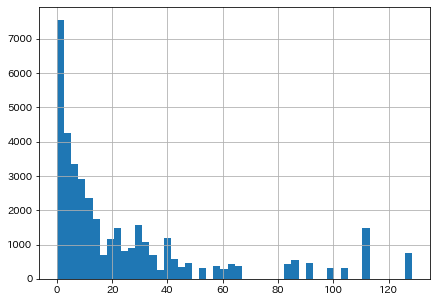

In [12]:
jam_neq0 = df_kannetsu[df_kannetsu['jam_quantity'] != 0]['jam_quantity']
fig, ax = plt.subplots(figsize=(7,5))
ax.hist(jam_neq0, bins=50)
ax.grid()
plt.show()

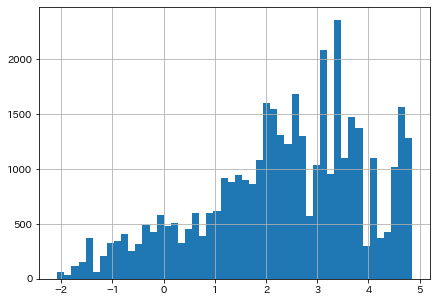

In [13]:
fig, ax = plt.subplots(figsize=(7,5))
ax.hist(np.log(jam_neq0), bins=50)
ax.grid()
plt.show()

In [14]:
def get_road_graph(df, road_code, direction='down'):
    '''
    特定の路線上のICのみから構成されるグラフを取得する関数
    （後のヒートマップによる可視化のために一直線のグラフを構築したい 
    → 上り・下りの違いで分岐が発生する路線（e.g. 東北道）が存在するためdirectionを指定する）

    Parameters
    --------------
    df: pandas.DataFrame
    ICの接続関係が格納されたデータフレーム
    road_code: str
    指定したい路線コード
    direction: {"down", "up"}
    上りか下りか

    Returns
    ----------
    road_graph: nx.DiGraph
    指定された路線上, 指定された方向のICのグラフ
    '''
    # 引数で指定した特定路線についての接続関係のみを抽出
    df = df[df['road_code'] == road_code]

    # ICグラフを構築
    road_graph = nx.from_pandas_edgelist(df, source='start_code', target='end_code',
                                      edge_attr=['direction'],
                                      create_using=nx.DiGraph())

    # 「上り or 下り」によってエッジの向きを変更
    # （これは後に路線上のICの順番をグラフから正しく取り出せるようにするための処理）
    if direction == 'down':
        sub_list = [(s, t, attr) for s, t, attr in road_graph.edges(data=True) if attr['direction'] == '下り']
    elif direction == 'up':
        sub_list = [(t, s, attr) for s, t, attr in road_graph.edges(data=True) if attr['direction'] == '上り']
    else:
        assert False, 'direction should be either down or up'
  
    # 路線, 方向（上り, 下り）が限定されたICのグラフを構築
    road_graph = nx.DiGraph()
    road_graph.add_edges_from(sub_list)

    return road_graph


def get_ic_order(df, road_code, direction='down'):
    '''
    特定路線上のICの順番をDict形式で取得する関数

    Parameters
    --------------
    df: pandas.DataFrame
    ICグラフの元になる接続関係データ
    road_code: str
    指定したい路線コード
    direction: {"down", "up"}
    上りか下りか

    Returns
    ----------
    ic_order_map: Dict[str, int]
    ICコード => 順番のマップ
    '''
    # 特定路線, 特定方向のICグラフを構築
    road_graph = get_road_graph(df, road_code, direction)

    # グラフのtraverseによって各ノード(IC)の順番を取得
    if direction == 'down':
        nodes = nx.dfs_postorder_nodes(road_graph)
        nodes = list(nodes)[::-1]
    elif direction == 'up':
        nodes = nx.dfs_postorder_nodes(road_graph)
    else:
        assert False, 'direction should be either down or up'
  
    ic_order_map = {code: i for i, code in enumerate(nodes)}

    return ic_order_map

In [15]:
order_tateyama = {
    'down': get_ic_order(df_icnet, '1130', direction='down'),
    'up': get_ic_order(df_icnet, '1130', direction='up')
}

order_kannetsu = {
    'down': get_ic_order(df_icnet, '1800', direction='down'),
    'up': get_ic_order(df_icnet, '1800', direction='up')
}

In [16]:
def init_congmat(sr, start, end=None, road_code='1130'):
    if sr[-1] == 'd':
        dt_format = '%Y-%m-%d'
        ts = [d.strftime(dt_format) for d in pd.date_range(start, end, freq=sr)]
    elif sr[-1] == 'h':
        dt_format = '%Y-%m-%d %H:%M'
        ts = [t.strftime(dt_format) for t in pd.date_range(start, periods=24 / int(sr[:-1]), freq=sr)]
    elif sr[-3:] == 'min':
        dt_format = '%Y-%m-%d %H:%M'
        ts = [t.strftime(dt_format) for t in pd.date_range(start, periods=24* (60 / int(sr[:-3])), freq=sr)]
    else:
        assert False, 'sr must be {1d, 1h, 5min}'

    n_ts = len(ts)

    if road_code == '1130':
        n_nodes_down = len(order_tateyama['down'])
        n_nodes_up = len(order_tateyama['up'])
    elif road_code == '1800':
        n_nodes_down = len(order_kannetsu['down'])
        n_nodes_up = len(order_kannetsu['up'])
    else:
        assert False, 'road_code must be {1130, 1800}'
  
    cong_mat_down = np.zeros((n_ts, n_nodes_down-1), dtype=int)
    cong_mat_up = np.zeros((n_ts, n_nodes_up-1), dtype=int)

    return cong_mat_down, cong_mat_up, ts


def get_congmat(df, sr, start, end=None, road_code='1130', time_col='datetime', num_col='allCars'):
    def f(arr, mat_down, mat_up, ic_order, ts_map):
        t = arr[time_col].strftime('%Y-%m-%d')
        if t not in ts_map:
            t = arr[time_col].strftime('%Y-%m-%d %H:%M')
        if t not in ts_map:
            return False

        start, end, n = arr[['start_code', 'end_code', num_col]]

        if ic_graph[start][end]['direction'] == '下り':
            ind = ic_order['down'][start]
            mat_down[ts_map[t], ind] = n
        else:
            ind = ic_order['up'][start]
            mat_up[ts_map[t], ind] = n

        return True

    if road_code == '1130':
        order = order_tateyama
    elif road_code == '1800':
        order = order_kannetsu
    else:
        assert False, 'road_code must be {1130, 1800}'

    mat_d, mat_u, ts = init_congmat(sr, start, end, road_code)

    ts_map = {t: i for i, t in enumerate(ts)}

    df.apply(f, axis=1, args=[mat_d, mat_u, order, ts_map])

    return mat_d, mat_u, ts

In [17]:
def plot_heatmap(mat, xlabel, ylabel, title, xticklabels, yticklabels, ax, fontdict_x={}, fontdict_y={}):
    xticks = range(len(xticklabels))
    yticks = range(0, mat.shape[0], 12)

    ## plot ##
    # fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
    sns.heatmap(mat, cbar=False, ax=ax)

    ## config ##
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_title(title, fontsize=20)

    ax.set_xticks(xticks)
    fontdict_x.update({
        'fontsize': 12,
        'horizontalalignment': 'right',
    })
    ax.set_xticklabels(labels=xticklabels, fontdict=fontdict_x, rotation=60)

    ax.set_yticks(ticks=yticks)
    fontdict_y.update({
        'fontsize': 14,
        'verticalalignment': 'center_baseline',
    })
    ax.set_yticklabels(labels=yticklabels, fontdict=fontdict_y, rotation=360)

    # plt.show()

In [18]:
df_tateyama['speed'].fillna(method='ffill', inplace=True)
df_kannetsu['speed'].fillna(method='ffill', inplace=True)

In [19]:
def get_oneday(df, year, month, day):
    return df[df['datetime'].dt.date == dt.date(year, month, day)]

In [20]:
sp_down, sp_up, ts = \
    get_congmat(get_oneday(df_tateyama, 2021, 5, 3), '5min', '20210503', road_code='1130', num_col='speed')

In [21]:
jam_down, jam_up, ts = \
    get_congmat(get_oneday(df_tateyama, 2021, 5, 3), '5min', '20210503', road_code='1130', num_col='jam_quantity')

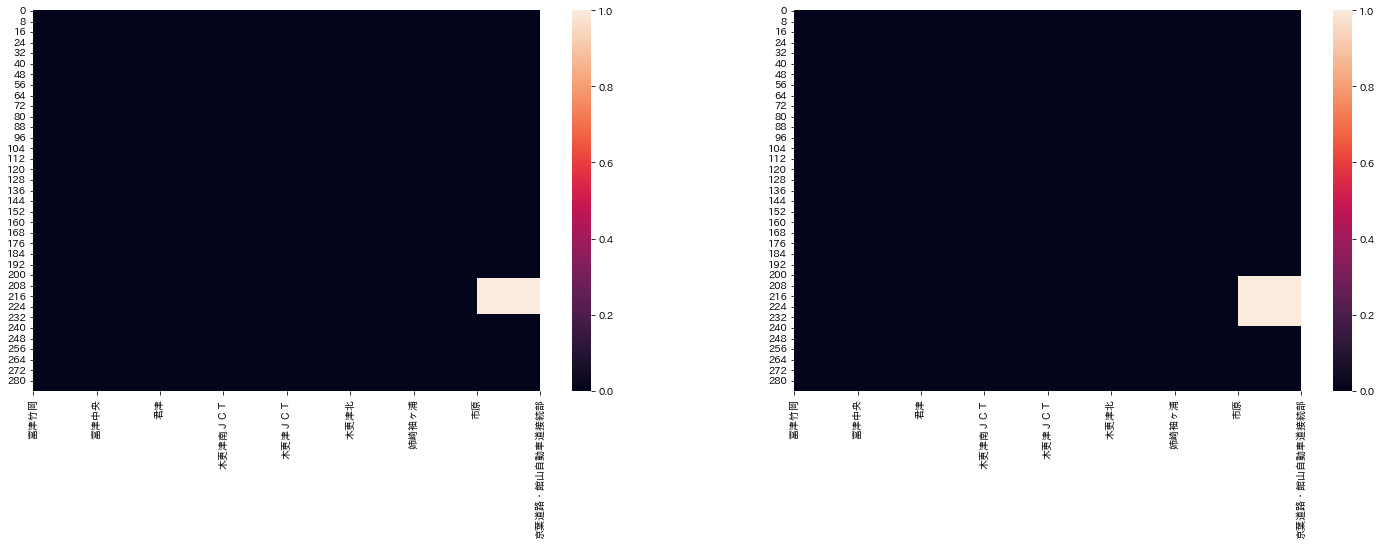

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(25,7))

sns.heatmap(sp_up < 40, ax=axes[0])
sns.heatmap(jam_up > 0, ax=axes[1])

xticklabels = [code2name[c] for c in order_tateyama['up'].keys()]
xticks = range(len(xticklabels))

axes[0].set_xticks(ticks=xticks, labels=xticklabels, rotation=90)
axes[1].set_xticks(ticks=xticks, labels=xticklabels, rotation=90)

plt.show()

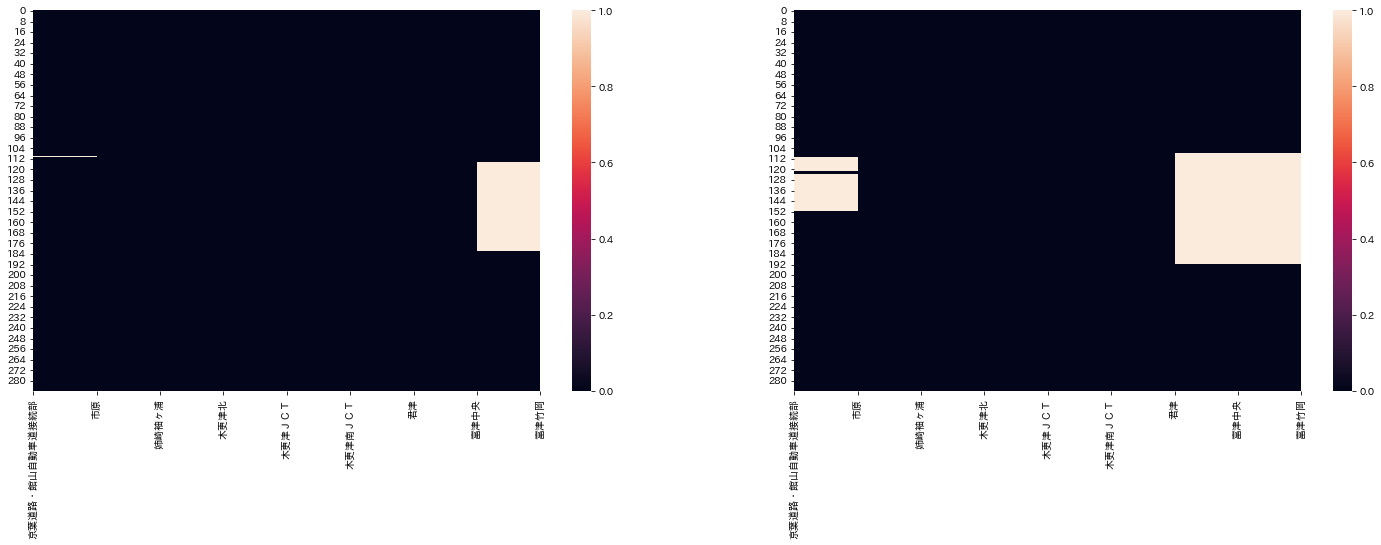

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(25,7))
sns.heatmap(sp_down < 40, ax=axes[0])
sns.heatmap(jam_down > 0, ax=axes[1])

xticklabels = [code2name[c] for c in order_tateyama['down'].keys()]
xticks = range(len(xticklabels))

axes[0].set_xticks(ticks=xticks, labels=xticklabels, rotation=90)
axes[1].set_xticks(ticks=xticks, labels=xticklabels, rotation=90)

plt.show()

In [24]:
sp_down, sp_up, ts = \
    get_congmat(get_oneday(df_kannetsu, 2021, 5, 4), '5min', '20210504', road_code='1800', num_col='speed')

In [25]:
jam_down, jam_up, ts = \
    get_congmat(get_oneday(df_kannetsu, 2021, 5, 4), '5min', '20210504', road_code='1800', num_col='jam_quantity')

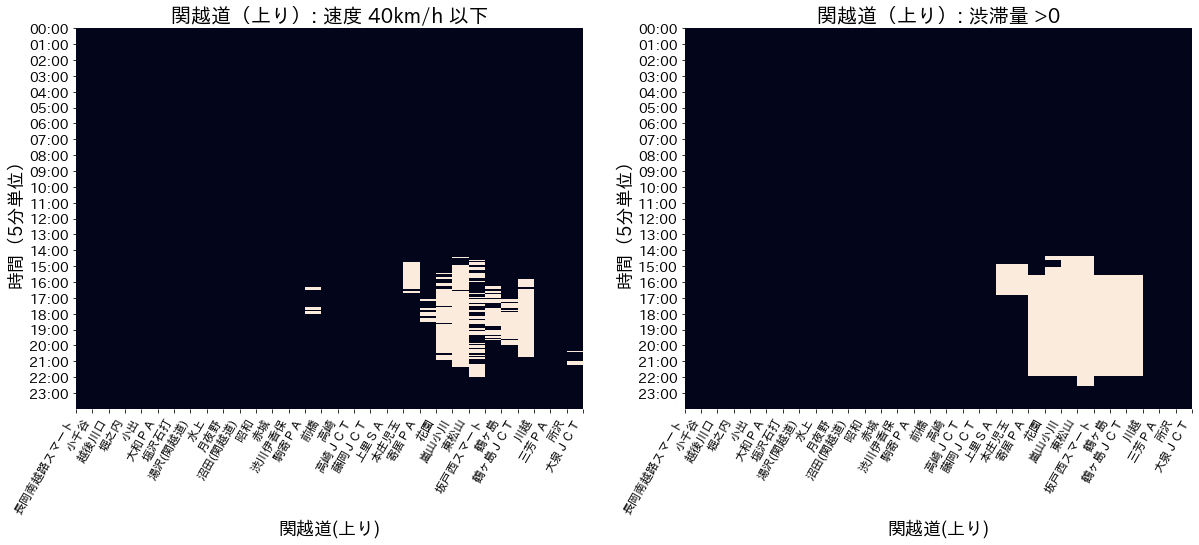

In [26]:
xlabel = '関越道(上り)'
ylabel = '時間（5分単位）'
title0 = '関越道（上り）: 速度 40km/h 以下'
title1 = '関越道（上り）: 渋滞量 >0'

xticklabels = [code2name[c] for c in order_kannetsu['up'].keys()]
yticklabels = [ts[i].split(' ')[1] for i in range(0, len(ts), 12)]

fig, axes = plt.subplots(1,2, figsize=(20,7))

plot_heatmap(sp_up < 40, xlabel, ylabel, title0, xticklabels, yticklabels, ax=axes[0])
plot_heatmap(jam_up > 0, xlabel, ylabel, title1, xticklabels, yticklabels, ax=axes[1])

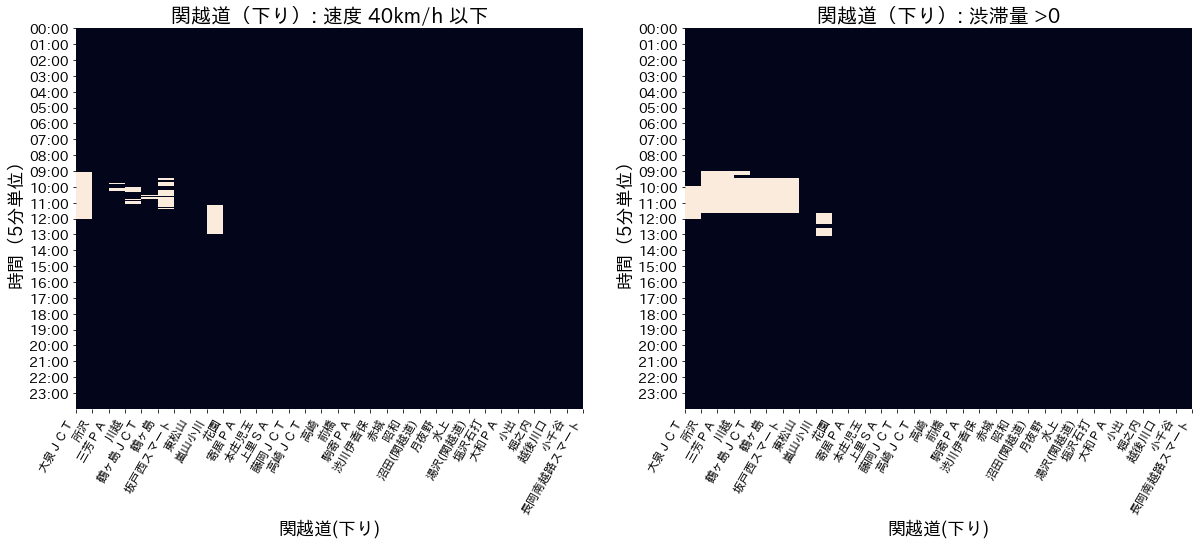

In [27]:
xlabel = '関越道(下り)'
ylabel = '時間（5分単位）'
title0 = '関越道（下り）: 速度 40km/h 以下'
title1 = '関越道（下り）: 渋滞量 >0'

xticklabels = [code2name[c] for c in order_kannetsu['down'].keys()]
yticklabels = [ts[i].split(' ')[1] for i in range(0, len(ts), 12)]

fig, axes = plt.subplots(1,2, figsize=(20,7))

plot_heatmap(sp_down < 40, xlabel, ylabel, title0, xticklabels, yticklabels, ax=axes[0])
plot_heatmap(jam_down > 0, xlabel, ylabel, title1, xticklabels, yticklabels, ax=axes[1])

In [28]:
intersec = ((sp_up <= 40) & (jam_up > 0)).sum()
union = ((sp_up <= 40) | (jam_up > 0)).sum()
intersec / union

0.5235109717868338

In [31]:
from tqdm import tqdm

In [32]:
DAYS = [d.strftime('%Y%m%d') for d in pd.date_range('20210401', '20211231')]

intersec = {'down': 0, 'up': 0}
union = {'down': 0, 'up': 0}

for d in tqdm(DAYS):
    year, month, day = int(d[:4]), int(d[4:6]), int(d[6:])
    tmp = get_oneday(df_kannetsu, year, month, day)
    
    sp_down, sp_up, ts = get_congmat(tmp, '5min', d, road_code='1800', num_col='speed')
    jam_down, jam_up, ts = get_congmat(tmp, '5min', d, road_code='1800', num_col='jam_quantity')
    
    intersec['down'] += ((sp_down <= 40) & (jam_down > 0)).sum()
    intersec['up'] += ((sp_up <= 40) & (jam_up > 0)).sum()
    union['down'] += ((sp_down <= 40) | (jam_down > 0)).sum()
    union['up'] += ((sp_up <= 40) | (jam_up > 0)).sum()    

100% 275/275 [1:53:02<00:00, 24.66s/it]


In [33]:
intersec, union

({'down': 5252, 'up': 8647}, {'down': 15546, 'up': 25253})

In [34]:
intersec['down'] / union['down']

0.33783609931815256

In [35]:
intersec['up'] / union['up']

0.34241476260246306

In [37]:
(intersec['down'] + intersec['up']) / (union['down'] + union['up'])

0.3406701144635898

In [39]:
DAYS = [d.strftime('%Y%m%d') for d in pd.date_range('20210401', '20211231')]

intersec = {'down': 0, 'up': 0}
union = {'down': 0, 'up': 0}

for d in tqdm(DAYS):
    year, month, day = int(d[:4]), int(d[4:6]), int(d[6:])
    tmp = get_oneday(df_tateyama, year, month, day)
    
    sp_down, sp_up, ts = get_congmat(tmp, '5min', d, road_code='1130', num_col='speed')
    jam_down, jam_up, ts = get_congmat(tmp, '5min', d, road_code='1130', num_col='jam_quantity')
    
    intersec['down'] += ((sp_down <= 40) & (jam_down > 0)).sum()
    intersec['up'] += ((sp_up <= 40) & (jam_up > 0)).sum()
    union['down'] += ((sp_down <= 40) | (jam_down > 0)).sum()
    union['up'] += ((sp_up <= 40) | (jam_up > 0)).sum()    

100% 275/275 [27:04<00:00,  5.91s/it]


In [41]:
print(intersec['down'] / union['down'])
print(intersec['up'] / union['up'])
print((intersec['down'] + intersec['up']) / (union['down'] + union['up']))

0.26763990267639903
0.4503311258278146
0.37635467980295567
